<a href="https://colab.research.google.com/github/sodiq-sulaimon/Receipts_Count_Prediction/blob/main/receipt_prediction/Receipt_Count_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error




### Download and inspect the data

In [ ]:
! wget https://fetch-hiring.s3.amazonaws.com/machine-learning-engineer/receipt-count-prediction/data_daily.csv

--2023-11-21 22:29:50--  https://fetch-hiring.s3.amazonaws.com/machine-learning-engineer/receipt-count-prediction/data_daily.csv
Resolving fetch-hiring.s3.amazonaws.com (fetch-hiring.s3.amazonaws.com)... 54.231.194.169, 52.216.165.243, 16.182.36.113, ...
Connecting to fetch-hiring.s3.amazonaws.com (fetch-hiring.s3.amazonaws.com)|54.231.194.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6981 (6.8K) [text/csv]
Saving to: ‘data_daily.csv’

data_daily.csv      100%[===================>]   6.82K  --.-KB/s    in 0s      

2023-11-21 22:29:50 (302 MB/s) - ‘data_daily.csv’ saved [6981/6981]



In [ ]:
# Read the data into pandas DataFrame
df = pd.read_csv('data_daily.csv')

In [ ]:
# df.head()

In [ ]:
# df.dtypes

In [ ]:
# Rename the columns
df = df.rename(columns= {'# Date' : 'date', 'Receipt_Count': 'receipt_count'})

In [ ]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

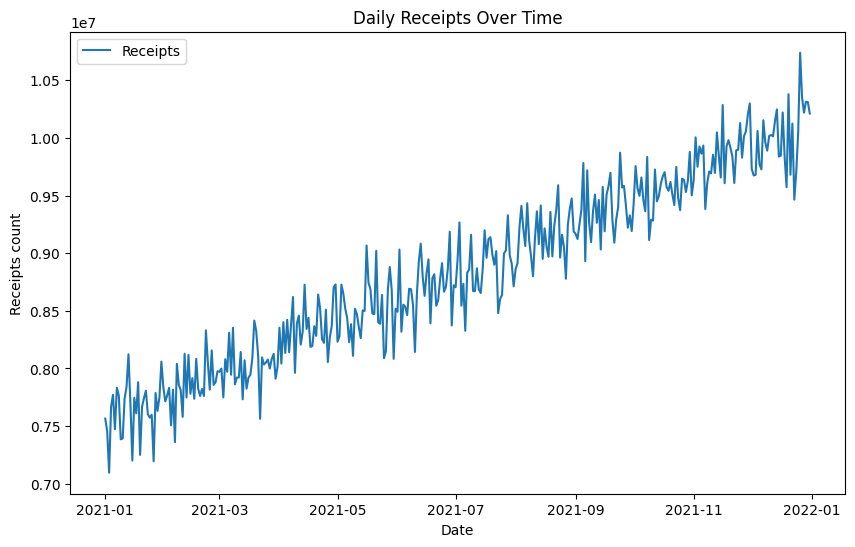

In [ ]:
# Visualize the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['receipt_count'], label='Receipts')
plt.title('Daily Receipts Over Time')
plt.xlabel('Date')
plt.ylabel('Receipts count')
plt.legend()
plt.show()

The data has upward trend but the seasonality is not very obvious

In [ ]:
# # Lag values for 7 days
# df['lag_1'] = df['receipt_count'].shift(1)
# df['lag_2'] = df['receipt_count'].shift(2)
# df['lag_3'] = df['receipt_count'].shift(3)
# df['lag_4'] = df['receipt_count'].shift(4)
# df['lag_5'] = df['receipt_count'].shift(5)
# df['lag_6'] = df['receipt_count'].shift(6)
# df['lag_7'] = df['receipt_count'].shift(7)

# df = df[['date', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'receipt_count']]
# df.head(10)

In [ ]:
# # Calculate autocorrelation function (ACF) and partial autocorrelation function (PACF)
# lag_acf = acf(df['receipt_count'], nlags=7)
# lag_pacf = pacf(df['receipt_count'], nlags=7, method='ols')

# # Plot ACF
# plt.figure(figsize=(12, 4))
# plt.subplot(121)
# plt.stem(lag_acf)
# plt.axhline(y=0, linestyle='--', color='gray')
# plt.title('Autocorrelation Function (ACF)')

# # Plot PACF
# plt.subplot(122)
# plt.stem(lag_pacf)
# plt.axhline(y=0, linestyle='--', color='gray')
# plt.title('Partial Autocorrelation Function (PACF')

# plt.tight_layout()
# plt.show()

<!-- The partial autocorrelation function shows a high correlation with the first lag and second lag but lesser correlation with the subsequent lags. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values. -->

In [ ]:
# # Recompute the lags. Using only the first two lags
# df['lag_1'] = df['receipt_count'].shift(1)
# df['lag_2'] = df['receipt_count'].shift(2)

In [ ]:
# # Drop the lags except the first two
# df = df[['date', 'lag_1', 'lag_2', 'receipt_count']]
# df.head(10)

In [ ]:
# df['rolling_mean'] = df['receipt_count'].rolling(window=7).mean()
# df = df[['date', 'lag_1', 'lag_2', 'rolling_mean', 'receipt_count']]
# df.head(10)

In [ ]:
# df.tail()

### Feature Engineering

In [ ]:
# Extract day of the week and month as additional features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day

In [ ]:
# df.tail()

In [ ]:
# Perform cyclical encoding for day of the week and month
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [ ]:
# df.head()

In [ ]:
# Drop original day_of_week, month, day_of_month columns
df = df.drop(['day_of_week', 'day_of_month', 'month'], axis=1)

In [ ]:
# df.head()

In [ ]:
# features = ['date', 'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos', 'month_sin', 'month_cos']
# target = ['receipt_count']

In [ ]:
# Split the data into features (X) and target variable (y)
X = df.drop(['date', 'receipt_count'], axis=1)
y = df['receipt_count']

In [ ]:
# Normalize the target variable using Min-Max scaling
y = y / 1e7

In [ ]:
# # Normalize the target variable using Min-Max scaling
# y = (y - y.min()) / (y.max() - y.min())

In [ ]:
# X.tail()

In [ ]:
# Split the data into training and validation sets

X.index = df.date
y.index = df.date

# Train the data with 9 months of data
train_set = X.loc[:'2021-09-30']
# train_label = y.loc[:'2021-09-30']
train_label_normalized = y.loc[:'2021-09-30']

# Validate it with 2 months of data
validation_set = X.loc['2021-10-01':'2021-11-30']
# validation_label = y.loc['2021-10-01':'2021-11-30']
validation_label_normalized = y.loc['2021-10-01':'2021-11-30']

# Test it with one month of data
test_set = X.loc['2021-12-01':'2021-12-31']
# test_label = y.loc['2021-12-01':'2021-12-31']
test_label_normalized = y.loc['2021-12-01':'2021-12-31']

### Preprocessing

In [ ]:
# # Normalize the target variable using Min-Max scaling
# scaler = MinMaxScaler()
# train_label_normalized = scaler.fit_transform(train_label.values.reshape(-1, 1)).flatten()

# validation_label_normalized = scaler.fit_transform(validation_label.values.reshape(-1, 1)).flatten()

# test_label_normalized = scaler.fit_transform(test_label.values.reshape(-1, 1)).flatten()

In [ ]:
# Create an XGBoost regression model
model = xgb.XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.2, objective='reg:squarederror', random_state=42, verbosity=3)

In [ ]:
# Train the model
model.fit(train_set, train_label_normalized)

[17:21:24] ======== Monitor (0): HostSketchContainer ========
[17:21:24] AllReduce: 0.01461s, 1 calls @ 14610us

[17:21:24] MakeCuts: 0.033841s, 1 calls @ 33841us

[17:21:24] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[17:21:26] ======== Monitor (0): Learner ========
[17:21:26] Configure: 0.001206s, 1 calls @ 1206us

[17:21:26] EvalOneIter: 0.000696s, 200 calls @ 696us

[17:21:26] GetGradient: 0.204098s, 200 calls @ 204098us

[17:21:26] PredictRaw: 0.000183s, 200 calls @ 183us

[17:21:26] UpdateOneIter: 1.67107s, 200 calls @ 1671067us

[17:21:26] ======== Monitor (0): GBTree ========
[17:21:26] BoostNewTrees: 1.43645s, 200 calls @ 1436452us

[17:21:26] CommitModel: 8.8e-05s, 200 calls @ 88us

[17:21:26] ======== Monitor (0): HistUpdater ========
[17:21:26] BuildHistogram: 0.386895s, 349 calls @ 386895us

[17:21:26] EvaluateSplits: 0.220947s, 549 calls @ 220947us

[17:21:26] InitData: 0.172466s, 200 calls @ 172466us

[17:21:26] InitRoot: 0.376425s, 200 calls @ 376425u

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions on the validation set
y_pred_normalized = model.predict(validation_set)

[17:21:26] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


In [ ]:
# y_pred_normalized

In [ ]:
# # Inverse transform the predicted values to get them back to the original scale
# y_pred = scaler.inverse_transform(y_pred_normalized.reshape(-1, 1)).flatten()

In [ ]:
# y_pred

In [ ]:
# validation_label

In [ ]:
# Evaluate the model performance on the normalized scale
mse = mean_squared_error(validation_label_normalized, y_pred_normalized)
print(f'Mean Squared Error (MSE) on the normalized data scale: {mse:.4f}')

mae = mean_absolute_error(validation_label_normalized, y_pred_normalized)
print(f'Mean Absolute Error (MAE) on the normalized data scale: {mae:.4f}')

Mean Squared Error (MSE) on the normalized data scale: 0.0065
Mean Absolute Error (MAE) on the normalized data scale: 0.0699


In [ ]:
# # Evaluate the model performance on the original scale
# mae = mean_absolute_error(validation_label, y_pred)
# print(f'Mean Absolute Error (MAE) on the original data scale: {mae:.2f}')

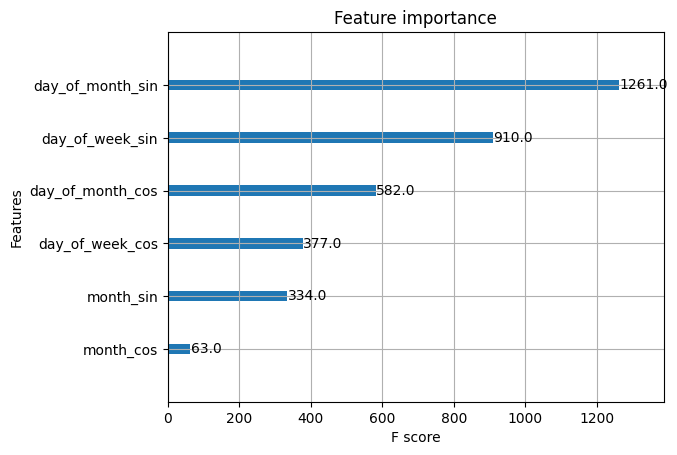

In [ ]:
# Feature importance plot
xgb.plot_importance(model)
plt.show()

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Create and train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_set, train_label_normalized)

# Make predictions on the validation set
y_pred = model.predict(validation_set)

# Evaluate the model performance
mse = mean_squared_error(validation_label_normalized, y_pred)
print(f'Mean Squared Error (MSE): {mse:.4f}')

mae = mean_absolute_error(validation_label_normalized, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

Mean Squared Error (MSE): 0.0045
Mean Absolute Error (MAE): 0.0575


In [ ]:
# Mean Squared Error (MSE): 0.0045
# Mean Absolute Error (MAE): 0.0575

# # Mean Squared Error (MSE): 0.0279
# # Mean Absolute Error (MAE): 0.1652

In [ ]:
# y_pred

In [ ]:
# validation_label_normalized

Random Forest performed better

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Build a simple neural network model
tf.keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(Dense(64, activation='linear', input_shape=([train_set.shape[1]])))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer='sgd', loss='mean_squared_error')  # Mean Squared Error (MSE) for regression

# Train the model
train_set = np.array(train_set)
model.fit(train_set, train_label_normalized, batch_size=30, epochs=500, verbose=0,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

# Evaluate the model performance on the test set
validation_set = np.array(validation_set)
y_pred = model.predict(validation_set)

mse = mean_squared_error(validation_label_normalized, y_pred)
print(f'Mean Squared Error (MSE): {mse:.4f}')

mae = mean_absolute_error(validation_label_normalized, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.4f}')



2/2 [==============================] - 0s 7ms/step
Mean Squared Error (MSE): 0.0146
Mean Absolute Error (MAE): 0.1149


In [ ]:
# SARIMA model
model = SARIMAX(train['receipt_count'],order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
result = model.fit(disp=False)

In [ ]:
# Make predictions for the test set
predictions = result.get_forecast(steps=len(test))
predicted_values = predictions.predicted_mean

In [ ]:
# Evaluate the model
mae = mean_absolute_error(test['receipt_count'], predicted_values)
print(f'Mean Absolute Error (MAE): {mae}')

In [ ]:
# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['receipt_count'], label='Train')
plt.plot(test['date'], test['receipt_count'], label='Test')
plt.plot(test['date'], predicted_values, label='Predicted', linestyle='--')
plt.title('SARIMA Model Prediction')
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.show()

In [ ]:
# Generate dates for the next year
next_year_dates = pd.date_range(df['date'].max() + pd.Timedelta(days=1), periods=365, freq='D')


In [ ]:
# Make predictions for the next year
forecast = result.get_forecast(steps=len(next_year_dates))
forecast_values = forecast.predicted_mean

In [ ]:
# Visualize predictions for the next year
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['receipt_count'], label='Historical Number of Receipts')
plt.plot(next_year_dates, forecast_values, label='Predicted Number of Receipts', linestyle='--')
plt.title('SARIMA Model Prediction for the Next Year')
plt.xlabel('Date')
plt.ylabel('Number of Receipts')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
# Calculate autocorrelation function (ACF) and partial autocorrelation function (PACF)
lag_acf = acf(df['receipt_count'], nlags=14)
lag_pacf = pacf(df['receipt_count'], nlags=14, method='ols')

# Plot ACF
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF')

plt.tight_layout()
plt.show()


In [ ]:
# y_pred

In [ ]:
# validation_label_normalized

## Model From Scratch

In [ ]:
import numpy as np
import pandas as pd

# Read the data into pandas DataFrame
df = pd.read_csv('data_daily.csv')

df = df.rename(columns={'# Date': 'date', 'Receipt_Count': 'receipt_count'})
df['date'] = pd.to_datetime(df['date'])

# Feature Engineering
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day

# Perform cyclical encoding for the days and month
# This helps to maintain the circular nature of days and months
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 7)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 7)

# Drop the original days and months columns
df = df.drop(['day_of_week', 'month', 'day_of_month'], axis=1)

# Split the data into features (X) and target variable (y)
X = df.drop(['date', 'receipt_count'], axis=1)
y = df['receipt_count']

# Normalize the target variable by dividing by 1e7
y = y / 1e7

# Split the data into training, validation and test sets
# Use date to index the data to allow splitting with months
X.index = df.date
y.index = df.date

# Train with 9 months of data
train_set = X.loc[:'2021-09-30']
train_label = y.loc[:'2021-09-30']

# Validate with 2 months of data
validation_set = X.loc['2021-10-01':'2021-11-30']
validation_label = y.loc['2021-10-01':'2021-11-30']

# Test with one month of data
test_set = X.loc['2021-12-01':]
test_label = y.loc['2021-12-01':]

# Convert the data to numpy arrays
train_set = np.array(train_set)
train_label = np.array(train_label)

validation_set = np.array(validation_set)
validation_label = np.array(validation_label)

test_set = np.array(test_set)
test_label = np.array(test_label)

# Build the model


In [ ]:
import math
import numpy as np
import copy

# Parameters w and b
initial_bias = 0.
initial_weights = np.zeros(X.shape[1])

def predict(X, weights, bias):
  prediction = np.dot(X, w) + b
  return prediction

# cost/loss
def compute_cost(X, y, weights, bias):
  m = X.shape[0] # m is number of training example
  cost = 0.0
  for i in range(m):
    forward_pass = np.dot(X[i], weights) + bias
    cost = cost + (forward_pass - y[i] ) ** 2
  cost = cost / (2 * m)
  return cost

def compute_gradient(X, y, weights, bias):
  m,n = X.shape
  dj_dw = np.zeros((n,))
  dj_db = 0.

  for i in range(m):
    error = (np.dot(X[i], weights) + bias) - y[i]
    for j in range(n):
      dj_dw[j] = dj_dw[j] + error * X[i, j]
    dj_db = dj_db + error
  dj_dw = dj_dw / m
  dj_db = dj_db / m

  return dj_dw, dj_db

  def gradient_descent(X, y, initial_weights, initial_bias, cost_function, gradient_function, learning_rate, num_iters):
  J_history = []
  w = copy.deepcopy(initial_weights)
  b = initial_bias

  for i in range(num_iters):
    dj_db, dj_dw = gradient_function(X, y, w, b)

  w = w - learning_rate * dj_dw
  b = b - learning_rate * dj_db

  if i<100000:
    J_history.append(cost_function(X, y, w, b))
  if i % math.ceil(num_iters / 10) == 0:
    print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}")

  return w, b, J_history



In [ ]:
# Parameters w and b
initial_bias = 0.
initial_weights = np.zeros(X.shape[1])

In [ ]:
def predict(X, weights, bias):
  prediction = np.dot(X, w) + b
  return prediction

In [ ]:
X.shape

(365, 6)

In [ ]:
# cost/loss
def compute_cost(X, y, weights, bias):
  m = X.shape[0] # m is number of training example
  cost = 0.0
  for i in range(m):
    forward_pass = np.dot(X[i], weights) + bias
    cost = cost + (forward_pass - y[i] ) ** 2
  cost = cost / (2 * m)
  return cost

In [ ]:
def compute_gradient(X, y, weights, bias):
  m,n = X.shape
  dj_dw = np.zeros((n,))
  dj_db = 0.

  for i in range(m):
    error = (np.dot(X[i], weights) + bias) - y[i]
    for j in range(n):
      dj_dw[j] = dj_dw[j] + error * X[i, j]
    dj_db = dj_db + error
  dj_dw = dj_dw / m
  dj_db = dj_db / m

  return dj_dw, dj_db

In [ ]:
compute_gradient(test_set, test_label, initial_weights, initial_bias)

(array([-0.03106305,  0.05966146,  0.0026734 , -0.00233192,  0.97476653,
         0.2224841 ]),
 -0.9998344645161292)

In [ ]:
def gradient_descent(X, y, initial_weights, initial_bias, cost_function, gradient_function, learning_rate, num_iters):
  J_history = []
  w = copy.deepcopy(initial_weights)
  b = initial_bias

  for i in range(num_iters):
    dj_db, dj_dw = gradient_function(X, y, w, b)

  w = w - learning_rate * dj_dw
  b = b - learning_rate * dj_db

  if i<100000:
    J_history.append(cost_function(X, y, w, b))
  if i % math.ceil(num_iters / 10) == 0:
    print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}")

  return w, b, J_history


In [ ]:
np.random.seed(42)

initial_w = np.random.rand(X.shape[1])
print(initial_w)
initial_b = 0.

[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452]


In [ ]:
w_final, b_final, J_hist = gradient_descent(train_set, train_label, initial_w, initial_b,
                                            compute_cost, compute_gradient, 0.01, 5000)

In [ ]:
w_final

array([-0.0018665 , -0.00476743, -0.00377116, -0.00313417,  0.0006989 ,
       -0.00019314])

In [ ]:
predictions = model(inputs)